## Project Overview

There are four major steps in my project:  
1. Enron dataset
2. Feature processing
3. Algorithm
4. Validation

In [119]:
import os

In [120]:
from IPython.display import Image
import matplotlib.pyplot as plt
import sys
import pickle
from sklearn import preprocessing
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
sys.path.append("../input/")


from feature_format import featureFormat
from feature_format import targetFeatureSplit

### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
features_list = ["poi"]

### load the dictionary containing the dataset
original = "../input/final_project_dataset.pkl"
destination = "final_dataset.pkl"

content = ''
outsize = 0
with open(original, 'rb') as infile:
    content = infile.read()
with open(destination, 'wb') as output:
    for line in content.splitlines():
        outsize += len(line) + 1
        output.write(line + str.encode('\n'))
        
data_dict = pickle.load(open("final_dataset.pkl", "rb") )

Firstly let's look how data is structured.

In [121]:
print ("There are ", len(data_dict.keys()), " executives in Enron Dataset.")

There are  146  executives in Enron Dataset.


In [122]:
print( data_dict.keys())

dict_keys(['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HAEDICKE MARK E', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'NOLES JAMES L', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY REX', 'LEMA

In [123]:
print (data_dict['BUY RICHARD B'])

{'salary': 330546, 'to_messages': 3523, 'deferral_payments': 649584, 'total_payments': 2355702, 'loan_advances': 'NaN', 'bonus': 900000, 'email_address': 'rick.buy@enron.com', 'restricted_stock_deferred': 'NaN', 'deferred_income': -694862, 'total_stock_value': 3444470, 'expenses': 'NaN', 'from_poi_to_this_person': 156, 'exercised_stock_options': 2542813, 'from_messages': 1053, 'other': 400572, 'from_this_person_to_poi': 71, 'poi': False, 'long_term_incentive': 769862, 'shared_receipt_with_poi': 2333, 'restricted_stock': 901657, 'director_fees': 'NaN'}


## The Enron Data

First of all I’d like to have a look at my data and check it for outliers. I plot salaries and bonuses on Enron employees and see an outlier in the data.

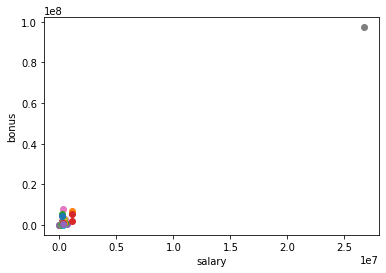

In [124]:
features = ["salary", "bonus"]
#data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)
### plot features
for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

When I check it I see this is a number for total salary and bonus. As this is not sensible information for our analysis I remove it manually. Two more outliers (SKILLING JEFFREY and LAY KENNETH) I keep in dataset as these values real and actually they are already a sign of these two managers being involved in the fraud. Now dataset look like this:

In [125]:
### remove any outliers before proceeding further
features = ["salary", "bonus"]
data_dict.pop('TOTAL', 0)
data = featureFormat(data_dict, features)

### remove NAN's from dataset
outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key, int(val)))

outliers_final = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])
### print top 4 salaries
print (outliers_final)

[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037)]


## Feature processing

After cleaning the data from outliers I had to pick the most sensible features to use. First I picked 'from_poi_to_this_person' and  'from_this_person_to_poi' but there is was no strong pattern when I plotted the data so I used fractions for both features of “from/to poi messages” and “total from/to messages”.

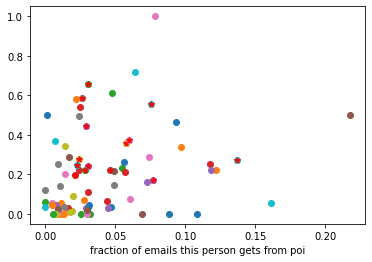

In [126]:
### create new features
### new features are: fraction_to_poi_email,fraction_from_poi_email

def dict_to_list(key,normalizer):
    new_list=[]

    for i in data_dict:
        if data_dict[i][key]=="NaN" or data_dict[i][normalizer]=="NaN":
            new_list.append(0.)
        elif data_dict[i][key]>=0:
            new_list.append(float(data_dict[i][key])/float(data_dict[i][normalizer]))
    return new_list

### create two lists of new features
fraction_from_poi_email=dict_to_list("from_poi_to_this_person","to_messages")
fraction_to_poi_email=dict_to_list("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["fraction_from_poi_email"]=fraction_from_poi_email[count]
    data_dict[i]["fraction_to_poi_email"]=fraction_to_poi_email[count]
    count +=1

    
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email"]    
    ### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)

### plot new features
for point in data:
    from_poi = point[1]
    to_poi = point[2]
    plt.scatter( from_poi, to_poi )
    if point[0] == 1:
        plt.scatter(from_poi, to_poi, color="r", marker="*")
plt.xlabel("fraction of emails this person gets from poi")
plt.show()

In order to find the most effective features for classification, feature selection using “Decision Tree”  was deployed to rank the features. Selection features was half manual iterative process. First I put all the possible features into features_list and then started deleting them one by one using score value and human intuition.

In [127]:
features_list = ["poi", "salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email",
                 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees']
data = featureFormat(my_dataset, features_list)

### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)

### split data into training and testing datasets
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state=42)




from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print ('accuracy', score)

print ("Decision tree algorithm time:", round(time()-t0, 3), "s")



importances = clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print ('Feature Ranking: ')
for i in range(16):
    print ("{} feature {} ({})".format(i+1,features_list[i+1],importances[indices[i]]))

accuracy 0.8
Decision tree algorithm time: 0.003 s
Feature Ranking: 
1 feature salary (0.21097674001435052)
2 feature bonus (0.15577986725663714)
3 feature fraction_from_poi_email (0.13827037103866766)
4 feature fraction_to_poi_email (0.10464601769911502)
5 feature deferral_payments (0.10424448339271349)
6 feature total_payments (0.10215959372485921)
7 feature loan_advances (0.06115676359039192)
8 feature restricted_stock_deferred (0.0557596223059662)
9 feature deferred_income (0.05351216814159292)
10 feature total_stock_value (0.013494372835705908)
11 feature expenses (0.0)
12 feature exercised_stock_options (0.0)
13 feature long_term_incentive (0.0)
14 feature shared_receipt_with_poi (0.0)
15 feature restricted_stock (0.0)
16 feature director_fees (0.0)


Finally I picked 10 features which are:
```
["salary", "bonus", "fraction_from_poi_email", "fraction_to_poi_email", 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value']
```



Finally I picked the following features:
**["fraction_from_poi_email", "fraction_to_poi_email", “shared_receipt_with_poi”]**

## Algorithm Selection and Tuning

In [128]:
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", "shared_receipt_with_poi"]

### try Naive Bayes for prediction
t0 = time()

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print ("Gaussian NB Accuracy : ",accuracy)

print ("NB algorithm time:", round(time()-t0, 3), "s")

from sklearn.ensemble import RandomForestClassifier
t0 = time()
clf3 = RandomForestClassifier(n_estimators=10)
clf3.fit(features_train, labels_train)
pred = clf3.predict(features_test)
rf_score = clf3.score(features_test, labels_test)

rf_acc = accuracy_score(labels_test, pred)
print ("RF accuracy: ", rf_acc)
print ("RF algorithm time:", round(time()-t0, 3), "s")

Gaussian NB Accuracy :  0.7333333333333333
NB algorithm time: 0.004 s
RF accuracy:  0.8666666666666667
RF algorithm time: 0.033 s


In [129]:
### use manual tuning parameter min_samples_split
clf = DecisionTreeClassifier(min_samples_split=5)

## Analysis Validation and Performance

In [130]:
### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label
features_list = ["poi", "fraction_from_poi_email", "fraction_to_poi_email", 'shared_receipt_with_poi']


### store to my_dataset for easy export below
my_dataset = data_dict


### these two lines extract the features specified in features_list
### and extract them from data_dict, returning a numpy array
data = featureFormat(my_dataset, features_list)


### split into labels and features (this line assumes that the first
### feature in the array is the label, which is why "poi" must always
### be first in features_list
labels, features = targetFeatureSplit(data)


### machine learning goes here!
### please name your classifier clf for easy export below

### deploying feature selection
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state=42)



from sklearn.tree import DecisionTreeClassifier


### use manual tuning parameter min_samples_split
t0 = time()
clf = DecisionTreeClassifier(min_samples_split=5)
clf = clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
print("done in %0.3fs" % (time() - t0))

acc=accuracy_score(labels_test, pred)

print ("accuracy after tuning = ", acc)


### dump my classifier, dataset and features_list so
### anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "wb") )
pickle.dump(data_dict, open("my_dataset.pkl", "wb") )
pickle.dump(features_list, open("my_feature_list.pkl", "wb") )

done in 0.002s
accuracy after tuning =  0.8888888888888888
